In [41]:
%matplotlib inline

In [40]:
import numpy as np
import pandas as pd
np.random.seed(151)

In [85]:
from chainer import Chain,Variable
import chainer
import chainer.links as L
import chainer.functions  as F
from chainer.datasets import split_dataset_random
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater,Trainer
from chainer.training.extensions import PrintReport,LogReport,Evaluator
from sklearn.preprocessing import StandardScaler
from chainer.datasets import TupleDataset
from chainer.optimizers import Adam
from sklearn.metrics import classification_report
from chainer.optimizers import SGD

In [59]:
# データの読み込み
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [60]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
#  入力データと正解データに分割
train_x = train.iloc[:,1:].values.astype(np.float32)
train_y = train.iloc[:,0].values.astype(np.int32)
test = test.values.astype(np.float32)

In [63]:
from sklearn.model_selection import train_test_split

In [70]:
# 訓練用データと検証用データに分割
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, train_size=0.8, random_state=1)

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [119]:
# データサイズの確認
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))
print("test:{}".format(test.shape))

train_x:(26880, 784)
train_y:(26880,)
valid_x:(6720, 784)
valid_y:(6720,)
test:(28000, 784)


In [35]:
train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [142]:
# モデルの定義
class Model(Chain):
    def __init__(self):
        super(Model,self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(784,1000)
            self.l2 = L.Linear(1000,800)
            self.l3 = L.Linear(800,100)
            self.l4 = L.Linear(100,10)

    
    def __call__(self,x):
        h = F.relu(self.l1(x))
        h = F.dropout(h,ratio=0.5)
        h = F.relu(self.l2(h))
        h = F.dropout(h,ratio=0.5)
        h = F.relu(self.l3(h))
        return self.l4(h)            

In [76]:
# 入力データと正解データをタプル型に変換
train_dataset = TupleDataset(train_x,train_y)
valid_dataset = TupleDataset(valid_x,valid_y)

In [92]:
len(valid_dataset[0][0])

784

In [100]:
# ミニバッチの作成
train_iterator = SerialIterator(train_dataset,batch_size = 100 , repeat=True)
valid_iterator = SerialIterator(valid_dataset,batch_size = 100 , shuffle=False,repeat=False)

In [143]:
# 学習の実行
model = Model()
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(10000,'iteration'))
trainer.extend(Evaluator(valid_iterator,classifier),trigger=(100,'iteration'))
trainer.extend(PrintReport(['iteration','main/loss','validation/main/loss', 'main/accuracy', 'validation/main/accuracy']))
logreport = LogReport(trigger=(100,'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
100         7.06526     0.909309              0.508          0.756765                  
200         1.09118     0.534885              0.7089         0.846618                  
300         0.785076    0.387752              0.7887         0.891912                  
400         0.621775    0.329337              0.8309         0.906912                  
500         0.520163    0.286604              0.8568         0.924412                  
600         0.430102    0.254481              0.8783         0.930441                  
700         0.398004    0.240556              0.8894         0.934265                  
800         0.352824    0.230216              0.9009         0.9375                    
900         0.314       0.212675              0.9095         0.940588                  
1000        0.304945    0.210366              0.9156         0.945588                  
1100        0.298583    0.187662  

9100        0.107273    0.130881              0.9746         0.970882                  
9200        0.0965911   0.160778              0.9747         0.971176                  
9300        0.118827    0.155647              0.9733         0.971471                  
9400        0.0971114   0.145077              0.9757         0.972206                  
9500        0.0906896   0.150794              0.9782         0.971618                  
9600        0.102378    0.141707              0.9735         0.968824                  
9700        0.108054    0.160371              0.974          0.968235                  
9800        0.102288    0.134579              0.9768         0.972941                  
9900        0.101081    0.194948              0.9756         0.969265                  


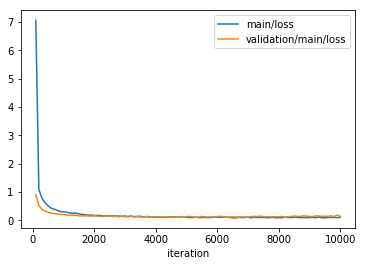

In [144]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

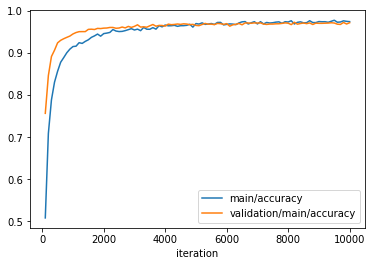

In [145]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[[ 'main/accuracy', 'validation/main/accuracy']].values, columns=[ 'main/accuracy', 'validation/main/accuracy'], index=log_df["iteration"]).plot()

In [146]:
# テストデータへモデルの当てはめ
y = model(test)

In [147]:
# 各出力で確率が高いものだけを抽出
pred = np.argmax(y.data,axis=1)

In [148]:
# 提出用にフォーマットを作成
submissions = pd.DataFrame({"ImageId": list(range(1,len(pred)+1)),"Label":pred})

In [149]:
# CSVへの書き出し
submissions.to_csv("digit_cnn_output.csv", index=False, header=True)